In [1]:
import sys
import time
import math
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.special import logit
from scipy.stats import norm

import tensorflow as tf
from keras import layers, models, datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR, LambdaLR
import torch.autograd.profiler as profiler

from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PowerTransformer
from sklearn.metrics import f1_score, log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def calculate_metrics(model, data_tensor, labels_tensor, batch_size=1024, num_features=22):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for start_idx in range(0, len(data_tensor), batch_size):
            end_idx = min(start_idx + batch_size, len(data_tensor))
            inputs = data_tensor[start_idx:end_idx].view(-1, num_features)
            labels = labels_tensor[start_idx:end_idx]

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, f1

In [3]:
class CustomDataLoader:
    def __init__(self, features, labels, validation_size=0.2, random_state=42, classification=True):        
        if validation_size > 0.0:
            stratify = labels if classification else None
            train_data, val_data, train_labels, val_labels = train_test_split(
                features, labels, test_size=validation_size, stratify=stratify, random_state=random_state
            )
            
            self.val_data_tensor = torch.tensor(val_data).float().to(device)
            
            if classification:
                self.val_labels_tensor = torch.tensor(val_labels).long().to(device)

            else:
                self.val_labels_tensor =torch.tensor(val_labels).float().to(device)
        else:
            train_data, train_labels = features, labels
            self.val_data_tensor, self.val_labels_tensor = None, None
        
        self.train_data_tensor = torch.tensor(train_data).float().to(device)

        if classification:
            self.train_labels_tensor = torch.tensor(train_labels).long().to(device)
        else:
            self.train_labels_tensor = torch.tensor(train_labels).float().to(device)

        torch.manual_seed(random_state)
        indices = torch.randperm(len(self.train_data_tensor))

        self.train_data_tensor = self.train_data_tensor[indices]
        self.train_labels_tensor = self.train_labels_tensor[indices]

In [4]:
def evaluate_model(model, custom_train_loader, criterion, optimizer, num_epochs, scheduler, batch_size=1024, num_features=22, early_stopping_patience=10):
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        i = 0
        total_loss = 0
        num_items = 0

        for start_idx in range(0, len(custom_train_loader.train_data_tensor), batch_size):
            end_idx = min(start_idx + batch_size, len(custom_train_loader.train_data_tensor))
            inputs = custom_train_loader.train_data_tensor[start_idx:end_idx].view(-1, num_features)
            labels = custom_train_loader.train_labels_tensor[start_idx:end_idx]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels, model)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * len(labels)
            total_loss += loss.item() * len(labels)
            num_items += len(labels)

            i += 1

        if epoch % 100 == 0:
            model.eval()
            for param_group in optimizer.param_groups:
                print("Learning Rate:", param_group['lr'])

            train_reg_loss = 0.0
            val_loss = 0.0
            with torch.no_grad():
                for start_idx in range(0, len(custom_train_loader.train_data_tensor), batch_size):
                    end_idx = min(start_idx + batch_size, len(custom_train_loader.train_data_tensor))
                    inputs = custom_train_loader.train_data_tensor[start_idx:end_idx].view(-1, num_features)
                    labels = custom_train_loader.train_labels_tensor[start_idx:end_idx]
        
                    outputs = model(inputs)
                    train_reg_loss += criterion.regular_loss(outputs, labels).item() * len(labels)

                val_iter = 0
                for start_idx in range(0, len(custom_train_loader.val_data_tensor), batch_size):
                    end_idx = min(start_idx + batch_size, len(custom_train_loader.val_data_tensor))
                    val_inputs = custom_train_loader.val_data_tensor[start_idx:end_idx].view(-1, num_features)
                    val_labels = custom_train_loader.val_labels_tensor[start_idx:end_idx]
    
                    val_outputs = model(val_inputs, val_iter)
                    val_loss += criterion.regular_loss(val_outputs, val_labels).item() * len(val_labels)
                    val_iter += 1
    
            avg_train_loss = running_loss / len(custom_train_loader.train_data_tensor)
            avg_val_loss = val_loss / len(custom_train_loader.val_data_tensor)
    
            # train_accuracy, train_f1 = calculate_metrics(model, custom_train_loader.train_data_tensor, custom_train_loader.train_labels_tensor, batch_size, num_features)
            # val_accuracy, val_f1 = calculate_metrics(model, custom_train_loader.val_data_tensor, custom_train_loader.val_labels_tensor, batch_size, num_features)
    
            print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
            print(f'Epoch {epoch + 1}, Training Loss: {train_reg_loss / len(custom_train_loader.train_data_tensor)}, Validation Loss: {avg_val_loss}')
            # print(f'Training Accuracy: {train_accuracy}, Training F1 Score: {train_f1}')
            # print(f'Validation Accuracy: {val_accuracy}, Validation F1 Score: {val_f1}')
            print()
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch + 1
                patience_counter = 0
            else:
                patience_counter += 10
                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs.')
                    print(f'Best Validation Loss: {best_val_loss} from Epoch {best_epoch}')
                    break

    if patience_counter < early_stopping_patience:
        print(f'Best Validation Loss after {num_epochs} epochs: {best_val_loss} from Epoch {best_epoch}')

In [5]:
data_dl = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
data_og = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')

data_dl = data_dl.drop(["id"], axis=1)

median_emp_length = data_og['person_emp_length'].median()
median_int_rate = data_og['loan_int_rate'].median()

data_dl['source'] = 0
data_og['source'] = 1

data = pd.concat([data_dl, data_og], ignore_index=True)

data['person_emp_length_missing'] = data['person_emp_length'].isna().astype(int)
data['loan_int_rate_missing'] = data['loan_int_rate'].isna().astype(int)

data['person_emp_length'] = data['person_emp_length'].fillna(median_emp_length)
data['loan_int_rate'] = data['loan_int_rate'].fillna(median_int_rate)

grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
data['loan_grade'] = data['loan_grade'].map(grade_mapping)

purpose_mapping = {
    'DEBTCONSOLIDATION': 1,
    'HOMEIMPROVEMENT': 2,
    'MEDICAL': 3,
    'PERSONAL': 4,
    'EDUCATION': 5,
    'VENTURE': 6
}
data['loan_intent'] = data['loan_intent'].map(purpose_mapping)

home_ownership_mapping = {
    'OWN': 1,
    'MORTGAGE': 2,
    'OTHER': 3,
    'RENT': 4
}
data['person_home_ownership'] = data['person_home_ownership'].map(home_ownership_mapping)

X = data.drop(["loan_status"], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = data["loan_status"]

column_to_log = [
    'person_age',
    'person_income',
]

column_to_sqrt = [
    'person_emp_length',
    'loan_percent_income',
]

for col in column_to_log:
    if (X[col] <= 0).any():
        print(f"Column '{col}' contains non-positive values. Adding 1 to avoid log of non-positive numbers.")
        X[col] = np.log(X[col] + 1)
    else:
        X[col] = np.log(X[col])

for col in column_to_sqrt:
    if (X[col] < 0).any():
        print(f"Column '{col}' contains negative values. Setting negative values to NaN before applying sqrt.")
        X[col] = np.sqrt(X[col].clip(lower=0))
    else:
        X[col] = np.sqrt(X[col])

print(data.isnull().sum())
print(X.columns)
print(X.shape, y.shape)
print(X.columns.get_loc('source'))

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
source                        0
person_emp_length_missing     0
loan_int_rate_missing         0
dtype: int64
Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'source', 'person_emp_length_missing', 'loan_int_rate_missing',
       'cb_person_default_on_file_Y'],
      dtype='object')
(91226, 14) (91226,)
10


In [6]:
x_scaler = StandardScaler()
x_scaled = x_scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(x_scaled.shape)

(91226, 14)


In [7]:
feature_means = x_scaled.mean(axis=0)
feature_variances = x_scaled.var(axis=0)
feature_mins = x_scaled.min(axis=0)
feature_maxs = x_scaled.max(axis=0)

feature_stats_scaled_full = pd.DataFrame({
    'Mean': feature_means,
    'Variance': feature_variances,
    'Min': feature_mins,
    'Max': feature_maxs
})

print("Mean, Variance, Min, and Max of Scaled Features:")
print(feature_stats_scaled_full)

Mean, Variance, Min, and Max of Scaled Features:
            Mean  Variance       Min        Max
0  -3.289997e-16       1.0 -1.552712   8.591255
1  -1.420680e-16       1.0 -5.315235   9.344027
2  -1.370832e-17       1.0 -1.810229   0.945472
3   3.987875e-17       1.0 -1.859550   8.913061
4   6.153166e-17       1.0 -1.591801   1.383254
5  -1.183900e-17       1.0 -4.464004   1.025387
6  -1.333446e-16       1.0 -1.513249   4.385625
7   9.327889e-16       1.0 -1.759487   4.065809
8  -5.358707e-16       1.0 -3.245038   4.413749
9   6.480297e-17       1.0 -0.943500   5.989958
10 -1.944089e-16       1.0 -0.745361   1.341632
11 -4.610980e-17       1.0 -0.099539  10.046317
12  6.729539e-17       1.0 -0.188056   5.317578
13  2.928596e-17       1.0 -0.433778   2.305326


In [8]:
class CustomLoss(nn.Module):
    def __init__(self, criterion, f1_lambda, f2_lambda, l1_lambda, l2_lambda, wa_lambda):
        super(CustomLoss, self).__init__()
        self.criterion = criterion
        self.f1_lambda = f1_lambda
        self.f2_lambda = f2_lambda
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.wa_lambda = wa_lambda
        self.i = 0

    def forward(self, outputs, labels, model): 
        f1_loss = 0.0
        f2_loss = 0.0
        l1_loss = 0.0
        l2_loss = 0.0

        for name, module in model.named_modules():
            if isinstance(module, CustomActivation):
                f1_loss += (module.a ** 2).sum() + (module.b ** 2).sum()
                f2_loss += ((module.a - module.b) ** 2).sum()

            if isinstance(module, nn.Linear):
                l1_loss += torch.norm(module.weight, 1)
                l2_loss += torch.norm(module.weight, 2) ** 2

        total_loss = (self.criterion(outputs, labels)
                      + self.f1_lambda * f1_loss
                      + self.f2_lambda * f2_loss
                      + self.l1_lambda * l1_loss
                      + self.l2_lambda * l2_loss)
        self.i += 1

        return total_loss

    def compute_gradient_magnitude(self, model):
        total_abs_sum = 0.0
        for param in model.parameters():
            if param.grad is not None:
                total_abs_sum += param.grad.abs().sum().item()
        self.grad_magnitude = total_abs_sum

    def regular_loss(self, outputs, labels):
        return self.criterion(outputs, labels)

In [9]:
class CustomActivation(nn.Module):
    def __init__(self, num_features, buffer_size=10, num_control_points=9, init_identity=True):
        super(CustomActivation, self).__init__()
        self.i = 0
        self.buffer_size = buffer_size
                
        self.a = nn.Parameter(torch.zeros(num_features, num_control_points))
        self.b = nn.Parameter(torch.zeros(num_features, num_control_points))

        self.local_bias = nn.Parameter(torch.zeros(num_features, num_control_points))
        self.global_bias = nn.Parameter(torch.zeros(1, num_features))

        self.a = torch.randn(num_features, num_control_points)
        self.b = torch.randn(num_features, num_control_points)

        with torch.no_grad():
            if init_identity:
                middle_index = num_control_points // 2
                self.a[:, middle_index] = 1.0
                self.b[:, middle_index] = 1.0

    def forward(self, x):
        
        x = x.unsqueeze(-1) + self.local_bias
        x = torch.where(x < 0, self.a * x, self.b * x)
        x = x.sum(dim=-1) + self.global_bias            
        return x

In [38]:
class CustomActivation(nn.Module):
    def __init__(self, num_features, buffer_size=10, num_control_points=9, width=50):
        super(CustomActivation, self).__init__()
        self.a = torch.randn(num_features, num_control_points).to(device)
        self.b = torch.randn(num_features, num_control_points).to(device)

        self.local_bias = torch.linspace(-width, width, num_control_points).repeat(num_features, 1).to(device)

    def forward(self, x):
        x = x.unsqueeze(-1) + self.local_bias
        x = torch.where(x < 0, self.a * x, self.b * x)
        x = x.sum(dim=-1)
        return x

In [39]:
# import torch
# import torch.nn as nn

# class CustomActivation(nn.Module):
#     def __init__(self, num_features, buffer_size=10, num_control_points=9, width=50):
#         super(CustomActivation, self).__init__()
#         self.num_features = num_features
#         num_control_points = 41
#         self.num_control_points = num_control_points

#         self.a = nn.Parameter(torch.randn(num_features, num_control_points))
#         self.b = nn.Parameter(torch.randn(num_features, num_control_points))

#         self.local_bias = nn.Parameter(torch.linspace(-width, width, num_control_points))

#     def forward(self, x):
#         output = torch.zeros_like(x)

#         for i in range(self.num_control_points):
#             shifted_x = x + self.local_bias[i]

#             output += torch.where(
#                 shifted_x < 0, 
#                 self.a[:, i] * shifted_x, 
#                 self.b[:, i] * shifted_x
#             )

#         return output

In [40]:
class CustomLinear(nn.Module):
    def __init__(self, num_features, num_outputs, init_identity=False):
        super(CustomLinear, self).__init__()
        
        # if init_identity and num_features != num_outputs:
        #     raise ValueError("For identity initialization, num_features must equal num_outputs.")

        self.linear = nn.Linear(num_features, num_outputs, bias=True)
        
        with torch.no_grad():
            self.linear.bias.zero_()

            # if init_identity:
            #     self.linear.weight.copy_(torch.eye(num_features, num_outputs))
            # else:
            #     self.linear.weight.zero_()

            if not init_identity:
                self.linear.weight.zero_()

    def forward(self, x):
        return self.linear(x)

In [47]:
class TabularDenseNet(nn.Module):
    def __init__(self, input_size, output_size, num_control_points, num_layers, window_size):
        super(TabularDenseNet, self).__init__()
        self.num_group = 64
        self.layer_1 = CustomActivation(input_size * self.num_group, 5, 20)
        self.layer_2 = CustomActivation(self.num_group, 5, 20)
        self.final = CustomLinear(self.num_group, output_size, init_identity=False)

        self.val_x = [None for i in range(100)]
        self.train_x = [None for i in range(100)]
        self.i = 0
        
    def forward(self, x, val_iter=None):
        x = x.repeat(1, self.num_group)
        x = self.layer_1(x)
        x = x.unfold(1, 14, 14).sum(dim=2)
        x = self.layer_2(x)

        return self.final(x)
        # if val_iter is not None:
        #     if self.val_x[val_iter] is not None:
        #         x = self.val_x[val_iter]
        #         return self.final(x)
        #     else:
        #         x = x.repeat(1, self.num_group)
        #         x = self.layer_1(x)
        #         x = x.unfold(1, 14, 14).sum(dim=2)
        #         x = self.layer_2(x)

        #         self.val_x[val_iter] = x.detach()
        #         x = self.final(x)
        #         return x

        # if self.i < 10:
        #     x = x.repeat(1, self.num_group)
        #     x = self.layer_1(x)
        #     x = x.unfold(1, 14, 14).sum(dim=2)
        #     x = self.layer_2(x)

        #     self.train_x[self.i % 10] = x.detach()
        # else:
        #     x = self.train_x[self.i % 10]
            
        # self.i += 1
        # x = self.final(x)
        # return x

In [17]:
# import torch.nn.functional as F

# class TabularDenseNet(nn.Module):
#     def __init__(self, input_size, output_size, num_control_points, num_layers, window_size):
#         super(TabularDenseNet, self).__init__()
#         self.num_group = 256 * 6
#         self.layer_1 = CustomLinear(input_size, input_size * 16, init_identity=True)
#         self.layer_2 = CustomLinear(input_size * 16, input_size * self.num_group, init_identity=True)
#         self.final = CustomLinear(input_size * self.num_group, output_size, init_identity=False)

#         self.i = 0
#         self.x_list = [None for i in range(10)]
#         self.x_val_list = [None for i in range(3)]

#         for param in self.layer_1.parameters():
#             param.requires_grad = False
#         for param in self.layer_2.parameters():
#             param.requires_grad = False

#         self.stored_x = None
#         self.stored_x_val = None
        
#     def forward(self, x, val_iter=None):
#         if self.stored_x is not None and val_iter is None:
#             return self.final(self.stored_x)
#         if self.stored_x_val is not None and val_iter is not None:
#             return self.final(self.stored_x_val)

#         x = self.layer_1(x)
#         x = F.relu(x)
#         x = self.layer_2(x)
#         x = F.relu(x)
#         print(x.shape)
        
#         if val_iter is None:
#             self.stored_x = x
#         else:
#             self.stored_x_val = x

#         return self.final(x)

#         # if val_iter:
#         #     if self.x_val_list[val_iter] is not None:
#         #         x = self.x_val_list[val_iter]
#         #         return self.final(x)
#         #     else:
#         #         x = self.layer_1(x)
#         #         x = F.relu(x)
#         #         x = self.layer_2(x)
#         #         x = F.relu(x)
#         #         self.x_val_list[val_iter] = x.detach()
#         #         return self.final(x)

#         # if self.i < 10:
#         #     x = self.layer_1(x)
#         #     x = F.relu(x)
#         #     x = self.layer_2(x)
#         #     x = F.relu(x)
#         #     self.x_list[self.i] = x.detach()
#         # else:
#         #     x = self.x_list[self.i % 10]

#         # self.i += 1
#         # x = self.final(x)
#         # return x

In [53]:
print(x_scaled.shape)

(91226, 14)


In [48]:
custom_train_loader = CustomDataLoader(x_scaled, y_encoded, validation_size=0.2, random_state=0, classification=True)
print(custom_train_loader.train_data_tensor.shape)

torch.Size([72980, 14])


In [49]:
models = []

In [50]:
feature_tensor = torch.empty((custom_train_loader.train_data_tensor.size(0), 0))
print(feature_tensor.shape)

torch.Size([72980, 0])


In [51]:
num_features = 14
num_classes = 2
num_control_points = 41
num_epochs = 10000
batch_size = 7298 * 1

In [35]:
for name, param in model.named_parameters():
    print(name)
    print(param)

layer_1.a
Parameter containing:
tensor([[-0.6702,  0.2361,  0.8290,  ..., -0.2312, -0.0621,  0.6341],
        [ 0.0468,  1.7785, -0.2693,  ...,  0.5128,  0.4180,  0.5795],
        [-0.1065,  1.3127, -1.0797,  ..., -0.3545, -1.4691, -1.6942],
        ...,
        [ 2.1793,  2.4107, -1.6754,  ...,  1.0180,  1.6123, -1.2275],
        [ 0.4764,  0.4330,  0.6436,  ..., -0.6466,  0.1749, -0.0196],
        [ 0.4806, -1.4551, -2.5456,  ...,  0.9486, -2.1704,  0.7256]],
       device='cuda:0', requires_grad=True)
layer_1.b
Parameter containing:
tensor([[ 1.5328,  0.5896, -0.4796,  ..., -0.6579,  1.9220,  0.5372],
        [ 2.1024,  0.9821, -0.1678,  ...,  0.2924, -1.8483, -2.5776],
        [ 0.7518,  0.5171, -0.5488,  ..., -0.0913,  0.7806,  0.1588],
        ...,
        [ 0.4202, -1.8980,  0.1207,  ...,  1.2828, -1.9447,  0.2433],
        [ 0.1236,  0.4643, -1.4194,  ...,  0.3370,  0.4962,  0.4576],
        [ 0.2270,  1.7739, -0.0756,  ..., -1.9056, -0.8622,  1.9557]],
       device='cuda:0', 

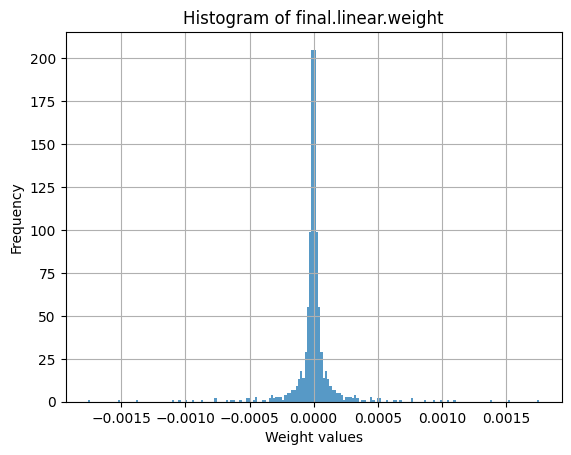

In [36]:
import torch
import matplotlib.pyplot as plt

final_linear_weight = model.final.linear.weight

weights = final_linear_weight.detach().cpu().numpy().flatten()

plt.hist(weights, bins=200, alpha=0.75)
plt.title('Histogram of final.linear.weight')
plt.xlabel('Weight values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace

# Assuming final.linear.weight is your tensor
weights = model.final.linear.weight.detach().cpu().numpy().flatten()

# Fit normal and Laplacian distributions to the data
mean, std = norm.fit(weights)
loc, scale = laplace.fit(weights)

# Create a range of values for the x-axis
x = np.linspace(min(weights), max(weights), 1000)

# Calculate the PDFs
normal_pdf = norm.pdf(x, mean, std)
laplacian_pdf = laplace.pdf(x, loc, scale)

# Plot the histogram and fitted distributions
plt.hist(weights, bins=200, density=True, alpha=0.6, label='Histogram')
plt.plot(x, normal_pdf, label='Normal PDF', linestyle='--')
plt.plot(x, laplacian_pdf, label='Laplacian PDF', linestyle='--')
plt.title('Fit Comparison: Normal vs. Laplacian')
plt.xlabel('Weight values')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'model' is not defined

In [42]:
from scipy.stats import kstest

# Test against normal distribution
ks_normal = kstest(weights, 'norm', args=(mean, std))

# Test against Laplacian distribution
ks_laplacian = kstest(weights, 'laplace', args=(loc, scale))

print("K-S Test for Normal Distribution:", ks_normal)
print("K-S Test for Laplacian Distribution:", ks_laplacian)


K-S Test for Normal Distribution: KstestResult(statistic=0.3538434206906831, pvalue=0.0, statistic_location=-2.7208716e-05, statistic_sign=-1)
K-S Test for Laplacian Distribution: KstestResult(statistic=0.2176632993794887, pvalue=0.0, statistic_location=1.1941935e-05, statistic_sign=1)


In [43]:
from scipy.stats import anderson

ad_result = anderson(weights, dist='norm')
print("Anderson-Darling Test for Normal Distribution:", ad_result)


Anderson-Darling Test for Normal Distribution: AndersonResult(statistic=1988.462997823679, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2.2737368e-12, scale=0.00016291751)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [33]:
torch.cuda.empty_cache()

In [87]:
import torch

# Tensor of shape (batch_size=3, num_features=28)
x = torch.arange(1, 85).view(3, 28).float()  # 3 samples, each with 28 features

print("Original tensor shape:", x.shape)
print(x)

# Unfold the second dimension (num_features) into sliding windows of size 14 with a stride of 14
x_unfolded = x.unfold(1, 14, 14)

print("\nUnfolded tensor shape:", x_unfolded.shape)
print(x_unfolded)

# Sum over the new dimension (dim=2) created by the unfold
x_summed = x_unfolded.sum(dim=2)

print("\nSummed tensor shape:", x_summed.shape)
print(x_summed)


Original tensor shape: torch.Size([3, 28])
tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
         15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.],
        [29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
         43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.],
        [57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70.,
         71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83., 84.]])

Unfolded tensor shape: torch.Size([3, 2, 14])
tensor([[[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.],
         [15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.]],

        [[29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.],
         [43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.]],

        [[57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70.],
         [71., 72., 73.

In [52]:
def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.99995 ** (step - num_step_threshold)

start_time = time.time()
model = TabularDenseNet(num_features, num_classes, num_control_points, 3, 10).to(device)

for name, param in model.named_parameters():
    print(name)
    print(param)
    
optimizer = optim.SGD(model.parameters(), lr=0.001 * 10.0)
optimizer = optim.Adam(model.parameters(), lr=0.001 * 1.0 * 0.001)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0, 0.0)
evaluate_model(model, custom_train_loader, criterion, optimizer, 100000, scheduler, batch_size, num_features, early_stopping_patience=10000)

models.append(model)
print(f"Execution time: {(time.time() - start_time):.6f} seconds")

final.linear.weight
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0', requires_grad=True)
final.linear.bias
Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Learning Rate: 1e-07
Epoch 1, Training Loss: 0.6855927467346191, Validation Loss: 0.6652988691569341
Epoch 1, Training Loss: 0.6653014302253724, Validation Loss: 0.6652988691569341

here
Learning Rate: 9.555185156327981e-07
Epoch 101, Training Loss: 0

KeyboardInterrupt: 

In [23]:
def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.99995 ** (step - num_step_threshold)

start_time = time.time()
model = TabularDenseNet(num_features, num_classes, num_control_points, 3, 10).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001 * 10.0)
optimizer = optim.Adam(model.parameters(), lr=0.001 * 10.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0, 0.0)
evaluate_model(model, custom_train_loader, criterion, optimizer, 100000, scheduler, batch_size * 100, num_features, early_stopping_patience=10000)

models.append(model)
print(f"Execution time: {(time.time() - start_time):.6f} seconds")

torch.Size([72980, 21504])
Learning Rate: 0.0001
torch.Size([18246, 21504])
Epoch 1, Training Loss: 0.6931450963020325, Validation Loss: 0.6931456923484802
Epoch 1, Training Loss: 0.6931450963020325, Validation Loss: 0.6931456923484802

here
Learning Rate: 0.0099995
Epoch 101, Training Loss: 0.3549061417579651, Validation Loss: 0.6106948256492615
Epoch 101, Training Loss: 0.6079214811325073, Validation Loss: 0.6106948256492615

Learning Rate: 0.00994962604194244
Epoch 201, Training Loss: 0.31942218542099, Validation Loss: 0.2537877559661865
Epoch 201, Training Loss: 0.24894890189170837, Validation Loss: 0.2537877559661865

Learning Rate: 0.009900000837491795
Epoch 301, Training Loss: 0.22309604287147522, Validation Loss: 0.23056474328041077
Epoch 301, Training Loss: 0.22304952144622803, Validation Loss: 0.23056474328041077

Learning Rate: 0.009850623145953332
Epoch 401, Training Loss: 0.2246573567390442, Validation Loss: 0.23013480007648468
Epoch 401, Training Loss: 0.22026780247688293

KeyboardInterrupt: 

In [24]:
for name, param in model.named_parameters():
    print(name)
    print(param)

layer_1.linear.weight
Parameter containing:
tensor([[-1.7794e-04, -4.9612e-02, -1.1179e-01,  ...,  1.5865e-01,
         -1.4340e-01, -2.1754e-01],
        [ 9.0345e-02,  5.4603e-02,  2.3221e-01,  ...,  1.4463e-01,
          1.3513e-01,  9.3167e-02],
        [-9.0080e-02,  2.6050e-01,  9.0216e-02,  ...,  1.7373e-02,
         -4.4720e-02, -5.2645e-03],
        ...,
        [-2.3088e-01, -1.1213e-01,  1.3565e-02,  ...,  2.6273e-01,
         -2.5864e-01,  1.5783e-01],
        [-2.4203e-01,  1.8848e-01,  2.5875e-01,  ...,  1.5293e-01,
          1.9342e-01,  1.3151e-01],
        [ 1.4840e-01, -5.3512e-02, -1.2958e-01,  ...,  1.1806e-01,
         -3.0606e-02,  7.1894e-02]], device='cuda:0')
layer_1.linear.bias
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Normal Distribution Fit:
  Mean: -7.671703315281775e-06, Std Dev: 0.7735763788223267
  K-S Test Statistic: 0.21106331501309428, p-value: 0.0

Laplacian Distribution Fit:
  Mean: 0.0, Scale: 0.29194854554675875
  K-S Test Statistic: 0.04948317944674219, p-value: 5.852132447621768e-92


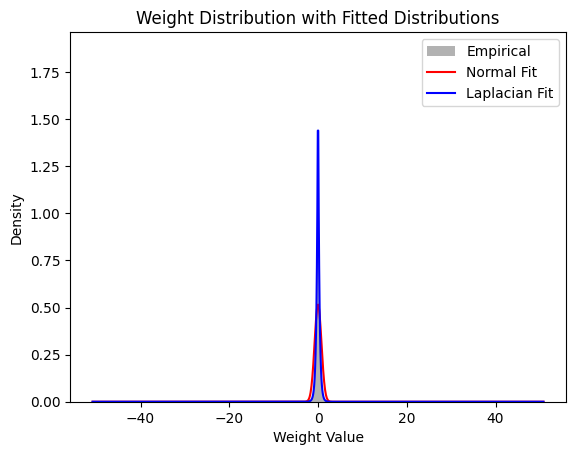

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace, kstest

# Assuming `param` is the tensor containing the weights
weights = model.final.linear.weight.detach().cpu().numpy().flatten()

# Fit Normal Distribution
mean_normal, std_normal = norm.fit(weights)

# Fit Laplacian Distribution
mean_laplace, scale_laplace = laplace.fit(weights)

# Kolmogorov-Smirnov Test
ks_normal = kstest(weights, 'norm', args=(mean_normal, std_normal))
ks_laplace = kstest(weights, 'laplace', args=(mean_laplace, scale_laplace))

# Print Test Results
print("Normal Distribution Fit:")
print(f"  Mean: {mean_normal}, Std Dev: {std_normal}")
print(f"  K-S Test Statistic: {ks_normal.statistic}, p-value: {ks_normal.pvalue}")

print("\nLaplacian Distribution Fit:")
print(f"  Mean: {mean_laplace}, Scale: {scale_laplace}")
print(f"  K-S Test Statistic: {ks_laplace.statistic}, p-value: {ks_laplace.pvalue}")

# Plot Distributions and Empirical Data
x = np.linspace(min(weights), max(weights), 1000)
pdf_normal = norm.pdf(x, mean_normal, std_normal)
pdf_laplace = laplace.pdf(x, mean_laplace, scale_laplace)

plt.hist(weights, bins=1000, density=True, alpha=0.6, color='gray', label='Empirical')
plt.plot(x, pdf_normal, 'r-', label='Normal Fit')
plt.plot(x, pdf_laplace, 'b-', label='Laplacian Fit')
plt.title("Weight Distribution with Fitted Distributions")
plt.xlabel("Weight Value")
plt.ylabel("Density")
plt.legend()
plt.show()


In [50]:
def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.99995 ** (step - num_step_threshold)

start_time = time.time()
model = TabularDenseNet(num_features, num_classes, num_control_points, 3, 10).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001 * 10.0)
optimizer = optim.Adam(model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0, 0.0)
evaluate_model(model, custom_train_loader, criterion, optimizer, 10000, scheduler, batch_size * 100, num_features, early_stopping_patience=10000)

models.append(model)
print(f"Execution time: {(time.time() - start_time):.6f} seconds")

torch.Size([72980, 28672])
Learning Rate: 1e-05
torch.Size([18246, 28672])
Epoch 1, Training Loss: 0.6931473612785339, Validation Loss: 0.6931473612785339
Epoch 1, Training Loss: 0.6931473612785339, Validation Loss: 0.6931473612785339

Learning Rate: 2e-05
Epoch 2, Training Loss: 0.6931473612785339, Validation Loss: 0.6783064007759094
Epoch 2, Training Loss: 0.6782563328742981, Validation Loss: 0.6783064007759094

Learning Rate: 3e-05
Epoch 3, Training Loss: 0.6782563328742981, Validation Loss: 0.650874137878418
Epoch 3, Training Loss: 0.650719165802002, Validation Loss: 0.650874137878418

Learning Rate: 4e-05
Epoch 4, Training Loss: 0.650719165802002, Validation Loss: 0.6153179407119751
Epoch 4, Training Loss: 0.6149970293045044, Validation Loss: 0.6153179407119751

Learning Rate: 5e-05
Epoch 5, Training Loss: 0.6149970293045044, Validation Loss: 0.5778284072875977
Epoch 5, Training Loss: 0.5772804021835327, Validation Loss: 0.5778284072875977

Learning Rate: 6e-05
Epoch 6, Training L

KeyboardInterrupt: 

In [ ]:
torch.set_printoptions(threshold=float('inf'), linewidth=200)


for name, param in model.named_parameters():
    print(name)
    print(param)

layer_1.linear.weight
Parameter containing:
tensor([[-1.7794e-04, -4.9612e-02, -1.1179e-01,  1.3254e-01,  8.0957e-02,  1.6317e-01, -9.8446e-02,  2.6680e-01,  8.2090e-02,  1.5345e-01, -2.6573e-01,  1.5865e-01, -1.4340e-01, -2.1754e-01],
        [ 9.0345e-02,  5.4603e-02,  2.3221e-01,  3.5820e-04, -2.0248e-01,  1.3884e-01,  1.8395e-01, -1.1233e-02,  2.0405e-02, -1.7900e-01,  1.9903e-01,  1.4463e-01,  1.3513e-01,  9.3167e-02],
        [-9.0080e-02,  2.6050e-01,  9.0216e-02, -8.2031e-02,  2.6675e-02, -1.3426e-01,  2.4115e-01,  8.7179e-02,  2.2191e-02,  5.0701e-02, -2.5366e-02,  1.7373e-02, -4.4720e-02, -5.2645e-03],
        [-6.8847e-02,  2.5165e-01,  2.0753e-01, -1.5881e-01, -1.1557e-01, -1.2935e-01, -2.4445e-01,  3.8486e-02, -2.5448e-01,  1.0821e-01,  3.3905e-02,  2.6198e-01, -1.0196e-01, -1.9220e-01],
        [-6.1130e-02, -2.4087e-01, -1.6049e-01,  1.2265e-01,  1.3486e-01, -2.3504e-01,  2.1390e-01, -2.4547e-01, -2.2743e-01,  2.5949e-02, -1.6097e-01, -2.1915e-01, -1.1450e-01, -2.5113e-0

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7dbdf518f370>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7dbdf518f370>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7dbdf518f370>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_t

In [ ]:
def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.99995 ** (step - num_step_threshold)

start_time = time.time()
model = TabularDenseNet(num_features, num_classes, num_control_points, 3, corr_comb_indices).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0, 0.0)
evaluate_model(model, custom_train_loader, criterion, optimizer, 10000, scheduler, batch_size, num_og_features, early_stopping_patience=10000)

models.append(model)
print(f"Execution time: {(time.time() - start_time):.6f} seconds")

In [ ]:
def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.99995 ** (step - num_step_threshold)

start_time = time.time()
model = TabularDenseNet(num_features, num_classes, num_control_points, 3, corr_comb_indices).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0, 0.0)
evaluate_model(model, custom_train_loader, criterion, optimizer, 10000, scheduler, batch_size, num_og_features, early_stopping_patience=10000)

models.append(model)
print(f"Execution time: {(time.time() - start_time):.6f} seconds")

In [ ]:
def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.99995 ** (step - num_step_threshold)

start_time = time.time()
model = TabularDenseNet(num_features, num_classes, num_control_points, 3, corr_comb_indices).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0, 0.0, 0.0)
evaluate_model(model, custom_train_loader, criterion, optimizer, 10000, scheduler, batch_size, num_og_features, early_stopping_patience=10000)

models.append(model)
print(f"Execution time: {(time.time() - start_time):.6f} seconds")

In [ ]:
data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

data = data.drop(["id"], axis=1)
data['source'] = 0

grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
data['loan_grade'] = data['loan_grade'].map(grade_mapping)

purpose_mapping = {
    'DEBTCONSOLIDATION': 1,
    'HOMEIMPROVEMENT': 2,
    'MEDICAL': 3,
    'PERSONAL': 4,
    'EDUCATION': 5,
    'VENTURE': 6
}
data['loan_intent'] = data['loan_intent'].map(purpose_mapping)

home_ownership_mapping = {
    'OWN': 1,
    'MORTGAGE': 2,
    'OTHER': 3,
    'RENT': 4
}
data['person_home_ownership'] = data['person_home_ownership'].map(home_ownership_mapping)

print(data.columns)
print(data.isnull().sum())

X = data.drop([], axis=1)

X = pd.get_dummies(X, drop_first=True)

column_to_log = [
    'person_age',
    'person_income',
]

column_to_sqrt = [
    'person_emp_length',
    'loan_percent_income',
]

for col in column_to_log:
    if (X[col] <= 0).any():
        print(f"Column '{col}' contains non-positive values. Adding 1 to avoid log of non-positive numbers.")
        X[col] = np.log(X[col] + 1)
    else:
        X[col] = np.log(X[col])

for col in column_to_sqrt:
    if (X[col] < 0).any():
        print(f"Column '{col}' contains negative values. Setting negative values to NaN before applying sqrt.")
        X[col] = np.sqrt(X[col].clip(lower=0))
    else:
        X[col] = np.sqrt(X[col])

print(X.shape)
print(X.columns)

In [ ]:
print(x_scaled)

In [ ]:
print(X.shape)
X_scaled_test = x_scaler.transform(X)
print(X_scaled_test.shape)
print(X_scaled_test)

In [ ]:
X_scaled_test_tensor = torch.tensor(X_scaled_test).float().to(device)
outputs = models[-1](X_scaled_test_tensor)
print(outputs)

In [ ]:
probabilities = F.softmax(outputs, dim=1)
print(probabilities)

In [ ]:
positive_class_probs = probabilities[:, 1]
print(positive_class_probs)

In [ ]:
import pandas as pd

test_df = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
ids = test_df['id']

positive_class_probs = positive_class_probs.cpu().detach().numpy()

submission_df = pd.DataFrame({
    'id': ids,
    'loan_status': positive_class_probs
})

submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully.")